In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import numpy as np
import yfinance as yf

from prophet import Prophet
# suggested by AI assistant
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [2]:
start='2019-01-01'
ticker='NVDA'

nvda = yf.download('NVDA', start='2019-01-01')

[*********************100%%**********************]  1 of 1 completed


In [4]:
nvda.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-20,139.800003,140.759995,129.520004,130.779999,130.779999,517768400
2024-06-21,127.120003,130.630005,124.300003,126.570000,126.570000,649445800


Prophet, Uni-variate Time-Series Model
---

$$y(t)=g(t)+s(t)+h(t)+\varepsilon(t)$$
where
where

 - $g(t)$ is the trend, the major composent in Prophet model, which uses a piecewise linear model for trend forecasting.
 - $s(t)$ represents periodic changes (weekly, monthly, yearly).
 - $h(t)$ represents the effects of holidays (recall: Holidays impact businesses).
 - $\varepsilon(t)$ is the error term.



In [34]:

df=pd.DataFrame()
df['ds']=nvda.index
df['y']=nvda['Close'].values
df.tail(2)

,ds,y
1375,2024-06-20,130.779999
1376,2024-06-21,126.570000


In [8]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjpneybn/qo9fbthn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjpneybn/k97amb9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84517', 'data', 'file=/tmp/tmprjpneybn/qo9fbthn.json', 'init=/tmp/tmprjpneybn/k97amb9r.json', 'output', 'file=/tmp/tmprjpneybn/prophet_modelj0s53ksu/prophet_model-20240622132200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
future = m.make_future_dataframe(periods=22)
future.tail()

,ds
1394,2024-07-09
1395,2024-07-10
1396,2024-07-11
1397,2024-07-12
1398,2024-07-13


In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1394,2024-07-09,105.008725,99.749459,109.869086
1395,2024-07-10,105.074303,100.162152,110.660878
1396,2024-07-11,105.546519,100.040936,110.701892
1397,2024-07-12,105.704917,100.889663,110.911108
1398,2024-07-13,104.510044,99.025075,109.691116


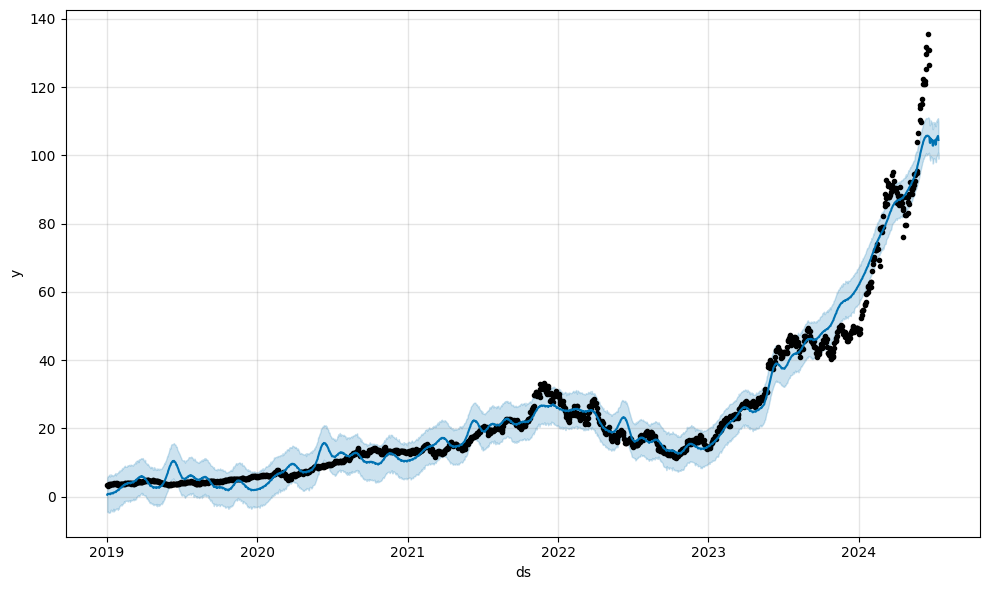

In [11]:
fig1 = m.plot(forecast)

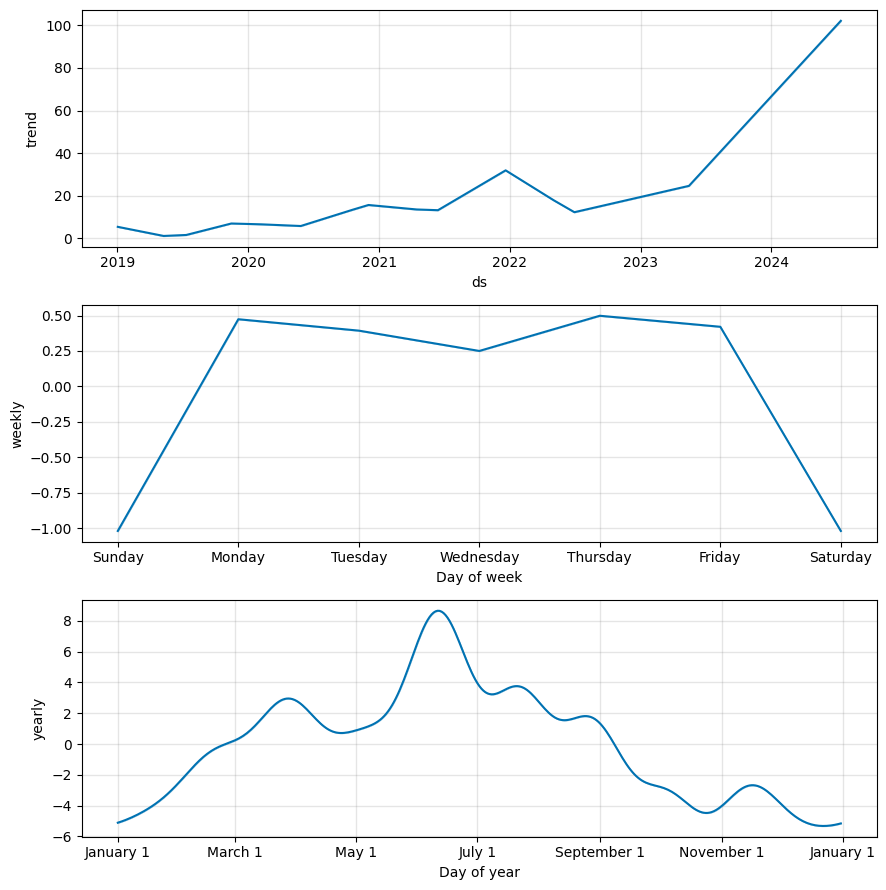

In [12]:
fig2 = m.plot_components(forecast)

In [13]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [14]:
plot_components_plotly(m, forecast)

Damped Trend
---

In [15]:
!pip install -q TSUtilities

In [20]:
y_train = df[:80]
y_test=df[80:]
future_y = df[80:]

future_trend = future_y

In [16]:
from TSUtilities.functions import dampen_prophet

In [17]:
prophet = Prophet()
prophet.fit(df)
fitted = prophet.predict()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjpneybn/utwqqex8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjpneybn/ot03cswd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93158', 'data', 'file=/tmp/tmprjpneybn/utwqqex8.json', 'init=/tmp/tmprjpneybn/ot03cswd.json', 'output', 'file=/tmp/tmprjpneybn/prophet_modelz8t_ntvc/prophet_model-20240622133431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
# create a future data frame
future = prophet.make_future_dataframe(periods=len(y_test))
forecast = prophet.predict(future)

In [22]:
predictions = forecast.tail(len(y_test))
predicted_trend = predictions['trend'].values
trend_component = fitted['trend'].values
seasonality_component = fitted['additive_terms'].values
forecasts_no_dampen = predictions['yhat'].values
forecasts_damped = dampen_prophet(y=y.values,fit_df=fitted,forecast_df=forecast)

In [28]:
forecasts_damped =dampen_prophet(y=df['y'].values,fit_df=fitted,forecast_df=forecast)

In [31]:
len(forecasts_damped),len(df)

(1297, 1377)

From Univariate to Multivariate
---

In [65]:
# lag feature
# weekly
df=pd.DataFrame()
df['ds']=nvda.index
df['y']=nvda['Close'].values

lag=5
df[f'lag_{lag}']=df['y'].shift(lag).fillna(0)

In [66]:
df.tail()

,ds,y,lag_5
1372,2024-06-14,131.880005,120.888000
1373,2024-06-17,130.979996,121.790001
1374,2024-06-18,135.580002,120.910004
1375,2024-06-20,130.779999,125.199997
1376,2024-06-21,126.570000,129.610001


In [67]:
m2 = Prophet()

# add new feature
m2.add_regressor('lag_5')

m2.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjpneybn/ho5jtq3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjpneybn/cdznbhkv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41331', 'data', 'file=/tmp/tmprjpneybn/ho5jtq3l.json', 'init=/tmp/tmprjpneybn/cdznbhkv.json', 'output', 'file=/tmp/tmprjpneybn/prophet_model59nqeuc4/prophet_model-20240622141546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [68]:
lag='week'

future = m2.make_future_dataframe(periods=5)
l1=list(df['lag_5'].values)

# fill the new feature
# ...
future['lag_5']=l1+list(df['y'].tail(5).values)

forecast = m2.predict(future)

In [69]:
plot_plotly(m2, forecast)

In [70]:
forecast[['yhat']].tail()

,yhat
1377,123.361814
1378,122.408172
1379,138.314634
1380,133.567608
1381,129.376535
